In [1]:
import pandas as pd
import numpy as nm
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

print('Packages imported')

Packages imported


In [2]:
def load_dataset(filename, sheet = 0):
    df=pd.read_excel(filename, sheet_name = sheet)
    return df

def drop_columns_rows(df):
    #killed = []
    for column in df:
        if df[column].isna().sum() > 150:
            df = df.drop(column, axis=1)
            #killed.append(column)
            
    #drops all rows with nan value
    df = df.dropna()
    return df

def split_dataframe(df):
    dataset = df.values
    X = dataset[:, 1:]
    y = dataset[:,0]
    return X,y

#All data
df = load_dataset('Dataset_LBP_RA.xlsx', 1)
X, y = split_dataframe(df)
print(X.shape)
X_orig_train, X_orig_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#Dropped features with lots of missing values
#Dropped rows with missing value
df = load_dataset('Dataset_LBP_RA.xlsx', 1)
df_drop = drop_columns_rows(df)
X_drop, y_drop = split_dataframe(df_drop)
print(X_drop.shape)
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size=0.25, random_state=1)



(1546, 36)
(1272, 30)


In [3]:
#Prepare X-values

#Changes all values to categorical values
def prepare_data(X_train, X_test):
    enc = OrdinalEncoder()
    return enc.fit_transform(X_train), enc.fit_transform(X_test)

#All data prepared, currently has nan values which makes these difficult to use
X_orig_train_prep, X_orig_test_prep = prepare_data(X_orig_train, X_orig_test)

#missing values columns and rows deleted. Dataset is (1272, 30).
X_drop_train_prep, X_drop_test_prep = prepare_data(X_drop_train, X_drop_test)


#Changes all missing values to placeholder number 999
def prepare_data_replace_missing(X_train, X_test):
    enc = OrdinalEncoder(encoded_missing_value = 999)
    return enc.fit_transform(X_train), enc.fit_transform(X_test)

#Missing values changed to placeholder number for the whole dataset (1546, 36).
X_placeholder_train_prep, X_placeholder_test_prep = prepare_data_replace_missing(X_orig_train, X_orig_test)



#If the 10 is numbered 9 then the categories array starts at 1 - special survey answers


In [4]:
#Prepare Y-values

def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

y_train_prep, y_test_prep = prepare_targets(y_train, y_test)
y_drop_train_prep, y_drop_test_prep = prepare_targets(y_drop_train, y_drop_test)
#y2_train_prep, y2_test_prep = prepare_targets(y_train, y_test)

In [5]:
def show_bar(df, fs):
    fs_scores_names = [(df.columns[x+1], y) for x, y in list(enumerate(fs.scores_))]
    fs_scores_names.sort(key=lambda x : x[1], reverse=True)

    names, scores = zip(*fs_scores_names)

    pyplot.bar(names, scores)
    pyplot.xticks(rotation=90)
    pyplot.show()

"""
def show_bar(df, fs):
    #df.info()
    #print(len(df.columns) , len(fs.scores_))
    for i in range( len(fs.scores_)):
        print('Feature %s: %f' % (df.columns[i+1], fs.scores_[i]))
    # plot the scores
    pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
    pyplot.show()
"""

"\ndef show_bar(df, fs):\n    #df.info()\n    #print(len(df.columns) , len(fs.scores_))\n    for i in range( len(fs.scores_)):\n        print('Feature %s: %f' % (df.columns[i+1], fs.scores_[i]))\n    # plot the scores\n    pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)\n    pyplot.show()\n"

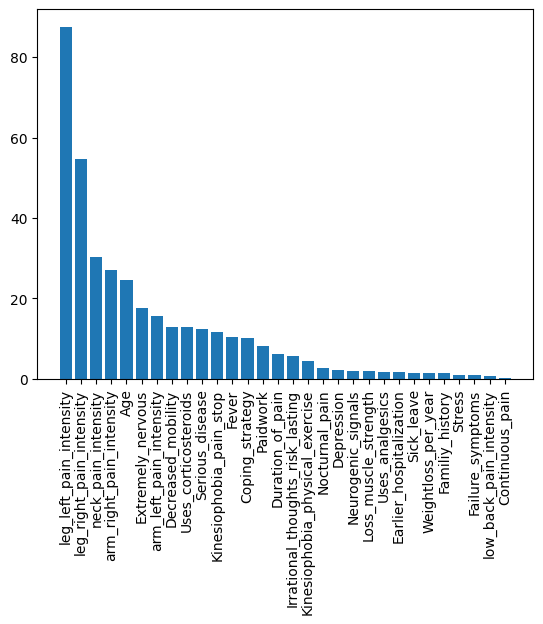

In [6]:
def select_features_chi2(X_train, y_train, X_test, n_features = "all"):
	fs = SelectKBest(score_func = chi2, k = n_features)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X_chi2_train_fs, X_chi2_test_fs, fsc1 = select_features_chi2(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)
show_bar(df_drop, fsc1)

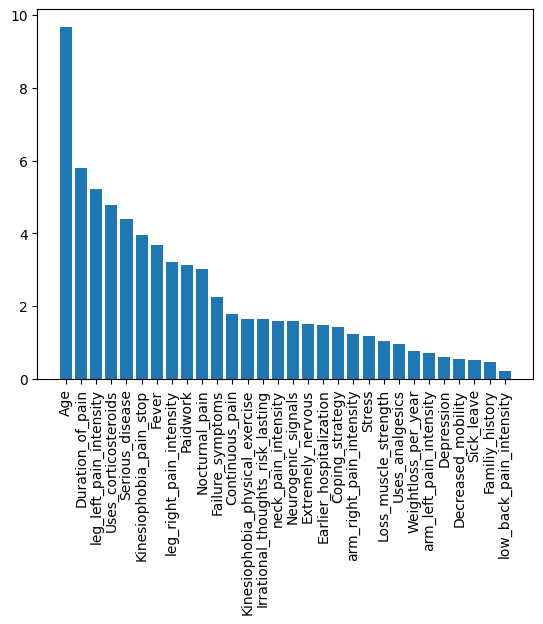

In [7]:
def select_features_fclassif(X_train, y_train, X_test, n_features = "all"):
	fs = SelectKBest(score_func = f_classif, k = n_features)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X_fclassif_train_fs, X_fclassif_test_fs, fsm1 = select_features_fclassif(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)
show_bar(df_drop, fsm1)

In [15]:
def get_accuracy(X_train_fs, X_test_fs, y_train_clean, y_test_clean):
    model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state = 1)
    model.fit(X_train_fs, y_train_clean)
    yhat = model.predict(X_test_fs)
    accuracy = accuracy_score(y_test_clean, yhat)
    return accuracy*100

print(get_accuracy(X_drop_train_prep, X_drop_test_prep, y_drop_train_prep, y_drop_test_prep))
print(get_accuracy(X_chi2_train_fs, X_chi2_test_fs, y_drop_train_prep, y_drop_test_prep))
print(get_accuracy(X_fclassif_train_fs, X_fclassif_test_fs, y_drop_train_prep, y_drop_test_prep))


44.0251572327044
43.39622641509434
40.25157232704403


In [22]:

#Accuracy for dropped dataset using LogisticRegression
df = load_dataset('Dataset_LBP_RA.xlsx', 1)
df_drop = drop_columns_rows(df)
X_drop, y_drop = split_dataframe(df_drop)
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size=0.25, random_state=1)
X_drop_train_prep, X_drop_test_prep = prepare_data(X_drop_train, X_drop_test)
y_drop_train_prep, y_drop_test_prep = prepare_targets(y_drop_train, y_drop_test)
X_chi2_train_fs, X_chi2_test_fs, fsc1 = select_features_chi2(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 20)
X_fclassif_train_fs, X_fclassif_test_fs, fsm1 = select_features_fclassif(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 20)
print(get_accuracy(X_drop_train_prep, X_drop_test_prep, y_drop_train_prep, y_drop_test_prep))
print(get_accuracy(X_chi2_train_fs, X_chi2_test_fs, y_drop_train_prep, y_drop_test_prep))
print(get_accuracy(X_fclassif_train_fs, X_fclassif_test_fs, y_drop_train_prep, y_drop_test_prep))


#Accuracy for placeholder dataset using LogisticRegression
df = load_dataset('Dataset_LBP_RA.xlsx', 1)
X, y = split_dataframe(df)
X_orig_train, X_orig_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_placeholder_train_prep, X_placeholder_test_prep = prepare_data_replace_missing(X_orig_train, X_orig_test)
y_train_prep, y_test_prep = prepare_targets(y_train, y_test)
X_chi2_train_fs, X_chi2_test_fs, fsc1 = select_features_chi2(X_placeholder_train_prep, y_train_prep, X_placeholder_test_prep, 15)
X_fclassif_train_fs, X_fclassif_test_fs, fsm1 = select_features_fclassif(X_placeholder_train_prep, y_train_prep, X_placeholder_test_prep, 15)
print(get_accuracy(X_placeholder_train_prep, X_placeholder_test_prep, y_train_prep, y_test_prep))
print(get_accuracy(X_chi2_train_fs, X_chi2_test_fs, y_train_prep, y_test_prep))
print(get_accuracy(X_fclassif_train_fs, X_fclassif_test_fs, y_train_prep, y_test_prep))




44.0251572327044
45.59748427672956
47.16981132075472
46.770025839793284
43.41085271317829
45.47803617571059


In [10]:
#Tryibg different svm models. None of them did better than 45 % accuracy

#Importing the necessary packages and libaries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np

#Accuracy for dropped dataset using SVM_linear_model
df = load_dataset('Dataset_LBP_RA.xlsx', 1)
df_drop = drop_columns_rows(df)
X_drop, y_drop = split_dataframe(df_drop)
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size=0.25, random_state=1)
X_drop_train_prep, X_drop_test_prep = prepare_data(X_drop_train, X_drop_test)
y_drop_train_prep, y_drop_test_prep = prepare_targets(y_drop_train, y_drop_test)
X_chi2_train_fs, X_chi2_test_fs, fsc1 = select_features_chi2(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)
X_fclassif_train_fs, X_fclassif_test_fs, fsm1 = select_features_fclassif(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)



svm_model_linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr').fit(X_drop_train_prep, y_drop_train_prep)
svm_predictions = svm_model_linear.predict(X_drop_test_prep)
accuracy = svm_model_linear.score(X_drop_test_prep, y_drop_test_prep)

#svm_model_rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovr').fit(X_drop_train_prep, y_drop_train_prep)
#svm_predictions = svm_model_rbf.predict(X_drop_test_prep)
#accuracy = svm_model_rbf.score(X_drop_test_prep, y_drop_test_prep)

#svm_model_poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovr').fit(X_drop_train_prep, y_drop_train_prep)
#svm_predictions = svm_model_poly.predict(X_drop_test_prep)
#accuracy = svm_model_poly.score(X_drop_test_prep, y_drop_test_prep)

#svm_model_sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovr').fit(X_drop_train_prep, y_drop_train_prep)
#svm_predictions = svm_model_sig.predict(X_drop_test_prep)
#accuracy = svm_model_sig.score(X_drop_test_prep, y_drop_test_prep)


cm = confusion_matrix(y_drop_test_prep, svm_predictions)

print(accuracy)

print("predicted value \u2192  actual value \u2193")
print("\n   1  2  3  4  5")
print(cm)



0.4559748427672956
predicted value →  actual value ↓

   1  2  3  4  5
[[82  0  0  1 41]
 [24  0  0  0 12]
 [ 5  0  0  0  6]
 [ 3  0  0  0  0]
 [81  0  0  0 63]]


In [11]:
#Accuracy for dropped dataset using RandomForestClassifier. 

from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

df = load_dataset('Dataset_LBP_RA.xlsx', 1)
df_drop = drop_columns_rows(df)
X_drop, y_drop = split_dataframe(df_drop)
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size=0.25, random_state=1)
X_drop_train_prep, X_drop_test_prep = prepare_data(X_drop_train, X_drop_test)
y_drop_train_prep, y_drop_test_prep = prepare_targets(y_drop_train, y_drop_test)
X_chi2_train_fs, X_chi2_test_fs, fsc1 = select_features_chi2(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)
X_fclassif_train_fs, X_fclassif_test_fs, fsm1 = select_features_fclassif(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)

"""
class_weight = compute_class_weight('balanced', classes = np.unique(y_drop_train_prep), y = y_drop_train_prep)
print(class_weight)
dct = {i : class_weight[i] for i in range (len(class_weight))}
print(dct)
#dct[0] = 1"""

clf=RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state = 1)
clf.fit(X_drop_train_prep,y_drop_train_prep)
y_pred=clf.predict(X_drop_test_prep)
print("Accuracy:",metrics.accuracy_score(y_drop_test_prep, y_pred))

cm = confusion_matrix(y_drop_test_prep, y_pred)
print("predicted value \u2192  actual value \u2193")
print("\n   1  2  3  4  5")
print(cm)


Accuracy: 0.44025157232704404
predicted value →  actual value ↓

   1  2  3  4  5
[[82  0  0  0 42]
 [25  1  0  0 10]
 [ 3  0  1  0  7]
 [ 1  0  0  0  2]
 [88  0  0  0 56]]


In [12]:
# Accuracy for dropped dataset using DecisionTreeClassifier. 

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

df = load_dataset('Dataset_LBP_RA.xlsx', 1)
df_drop = drop_columns_rows(df)
X_drop, y_drop = split_dataframe(df_drop)
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size=0.25, random_state=1)
X_drop_train_prep, X_drop_test_prep = prepare_data(X_drop_train, X_drop_test)
y_drop_train_prep, y_drop_test_prep = prepare_targets(y_drop_train, y_drop_test)
X_chi2_train_fs, X_chi2_test_fs, fsc1 = select_features_chi2(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)
X_fclassif_train_fs, X_fclassif_test_fs, fsm1 = select_features_fclassif(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)


classifier = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
classifier.fit(X_drop_train_prep, y_drop_train_prep)
y_pred_test =classifier.predict(X_drop_test_prep)

accuracy = metrics.accuracy_score(y_drop_test_prep, y_pred_test)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_drop_test_prep,y_pred_test)
print('Confusion Matrix: \n', cm)


Accuracy: 0.45
Confusion Matrix: 
 [[78  0  0  0 46]
 [23  0  0  0 13]
 [ 5  0  0  0  6]
 [ 3  0  0  0  0]
 [80  0  0  0 64]]


[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5')]

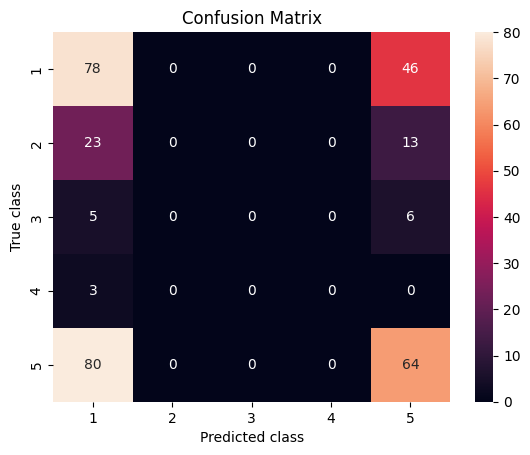

In [13]:
#Shows a Confusion matrix (cm) with the predicted and true values.

import seaborn as sb
import matplotlib.pyplot as plt     

ax= plt.subplot()
sb.heatmap(cm, annot=True, ax=ax)  

nums = [str(x) for x in range(1,6)]
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(nums)
ax.yaxis.set_ticklabels(nums)

In [ ]:
df = load_dataset('Dataset_LBP_RA.xlsx', 1)
df_drop = drop_columns_rows(df)
X_drop, y_drop = split_dataframe(df_drop)
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size=0.25, random_state=1)
X_drop_train_prep, X_drop_test_prep = prepare_data(X_drop_train, X_drop_test)
y_drop_train_prep, y_drop_test_prep = prepare_targets(y_drop_train, y_drop_test)
X_chi2_train_fs, X_chi2_test_fs, fsc1 = select_features_chi2(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)
X_fclassif_train_fs, X_fclassif_test_fs, fsm1 = select_features_fclassif(X_drop_train_prep, y_drop_train_prep, X_drop_test_prep, 10)



clf=RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state = 1)
clf.fit(X_drop_train_prep,y_drop_train_prep)
y_pred=clf.predict(X_drop_test_prep)
print("Accuracy:",metrics.accuracy_score(y_drop_test_prep, y_pred))

